<font size=8> Network Tests


In [1]:
#Common Python Packages
from pickle import TRUE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import timeout_decorator

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product
#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio



@timeout_decorator.timeout(40)  # Set a 5-second timeout
def run_simulation(neuron_config):
    return pc_pv_sst.pc_pv_sst(
        board=board,
        profile_path=profile_path,
        number_of_chips=number_of_chips,
        neuron_config=neuron_config
    )

<font size=7> Manual Tuning


In [2]:
[board,profile_path,number_of_chips]=obtain_board()

In [3]:
neuron_config=neuron_configs_bio.config()

neuron_config['SST_W0']=[2,150]#input weight to PC
neuron_config['SST_W1']=[4,200]#PC to SST weight
neuron_config['SST_W2']=[0,50]#PV shunt inhibition to SST


neuron_config['SST_AMPA_GAIN']=[1,100]
neuron_config['SST_AMPA_TAU']=[1,10]
neuron_config['SST_LEAK']=[0,10]

neuron_config['Input_SST']=.2#.1#.1

neuron_config['PC_SST']=.1#.1


neuron_config['PC_Adaptation']=True
neuron_config['duration']=1
neuron_config['input_type']='Regular'
neuron_config['in_freq']=20

[output_events,test_config]=pc_pv_sst.pc_pv_sst(board=board, profile_path=profile_path, number_of_chips=number_of_chips,neuron_config=neuron_config)
[cv_values,synchrony_values]=run_dynamic_anal(output_events,test_config)
if 'raster_fig' in locals() and raster_fig is not None:
    raster_fig.savefig('raster_previous.png')
if 'fvt_fig' in locals() and fvt_fig is not None:
    fvt_fig.savefig('fvt_previous.png')
raster_fig=script_annotated_raster_plot(test_config,output_events,neuron_config,cv_values=cv_values,syn_values=synchrony_values,save=True,annotate=False,annotate_network=True)
fvt_fig=frequency_vs_time_plot(frequency_over_time(test_config,output_events),test_config,save=True,annotate=False)
raster_fig.savefig('raster_current.png')
fvt_fig.savefig('fvt_current.png')



Setting Latches
Setting up network
Adding connections

Setting monitors
20 100 10

All configurations done!

Input events created
initilize run dynapse
dummy events sent

getting fpga time


setting virtual neurons

Simulation done
PC_CV_average: 0.07 PV_CV_average: 0.31 SST_CV_average: 0.0
PC_synchrony: 0.24 PV_CV_average: 0.45 SST_CV_average: 0.0


In [7]:

def calculate_slope(time_axis, ff_windows_sst):
    slope, intercept, r_value, p_value, std_err = linregress(time_axis, ff_windows_sst)
    return slope


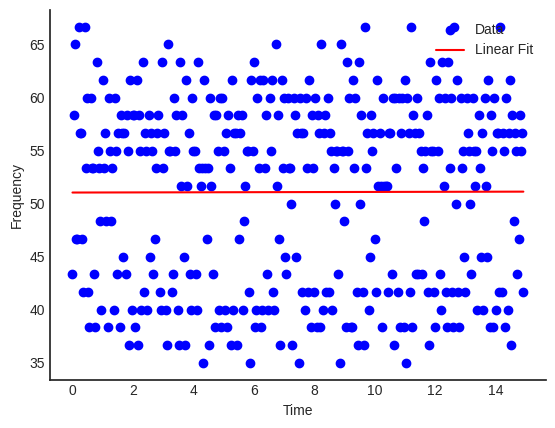

In [21]:
# Setting Seaborn style

# Your function call for frequency over time
[time_axis,ff_windows_pc,ff_windows_pv,ff_windows_sst] = frequency_over_time(test_config,output_events)

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(time_axis, ff_windows_sst)

# Scatter plot of the data
plt.scatter(time_axis, ff_windows_sst, label='Data', color='blue')

# Line plot of the linear regression
plt.plot(time_axis, intercept + slope * np.array(time_axis), label='Linear Fit', color='red')

# Labels
plt.xlabel('Time')
plt.ylabel('Frequency')

# Removing right and top axes
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Legend
plt.legend()

# Displaying the plot
plt.show()

In [6]:
cv_values=[]
synchrony_values=[]
pc_rates=[]
pc_pc_range=np.linspace(0,1,11)

for pc_pc in pc_pc_range:
    neuron_config['PC_PC']=pc_pc
    [output_events,test_config]=pc_pv_sst.pc_pv_sst(board=board, profile_path=profile_path, number_of_chips=number_of_chips,neuron_config=neuron_config)
    [cv_values_temp,synchrony_values_temp]=run_dynamic_anal(output_events,test_config)
    cv_values.append(cv_values_temp)
    rates=spike_count(output_events=output_events)
    pop_rates(rates,test_config)
    synchrony_values.append(synchrony_values_temp)


Setting Latches
Setting up network
Adding connections

Setting monitors
20 100 10

All configurations done!

Input events created
initilize run dynapse
dummy events sent


KeyboardInterrupt: 

In [5]:
print(np.linspace(0,1,11))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
